## Polylogarithmic-depth mcx circuit with a single borrowed ancilla

### setup

In [2]:
# !pip install qiskit
# !pip install qiskit_aer
# !pip install pylatexenc

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
import numpy as np
from qiskit.primitives import Sampler
from qiskit.visualization import circuit_drawer
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import Fake20QV1, GenericBackendV2
from qiskit.visualization import plot_coupling_map
import pickle
n=4

In [3]:
coupling_map = Fake20QV1().configuration().coupling_map
num_qubits = Fake20QV1().configuration().num_qubits
# plot_coupling_map(  num_qubits=num_qubits,
#                     qubit_coordinates=[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],
#                                     [1, 0], [1, 1], [1, 2], [1, 3], [1, 4],
#                                     [2, 0], [2, 1], [2, 2], [2, 3], [2, 4],
#                                     [3, 0], [3, 1], [3, 2], [3, 3], [3, 4]],
#                     coupling_map=coupling_map)

### comparison

In [4]:
standard_mcx_circuit = QuantumCircuit(n+2)
standard_mcx_circuit.initialize('00'+'1'*n, standard_mcx_circuit.qubits)
standard_mcx_circuit.mcx([i for i in range(n)], n+1)
# print('depth standard in Qiskit:',transpile(standard_mcx_circuit, backend=Fake20QV1(), optimization_level=3).depth()-2)
# standard_mcx_circuit.decompose(reps=2).draw(output='mpl', filename='standard_mcx_circuit.png')

standard_mcx_circuit.measure_all()
Sampler(options={'shots':1e2}).run(standard_mcx_circuit).result().quasi_dists[0].binary_probabilities()

{'101111': 1.0}

In [5]:
def get_custom_mcx(num_ctrl_qubits, save_fig=False, custom_gates=None):

    if num_ctrl_qubits == 1:
        custom_mcx = QuantumCircuit(3)
        custom_mcx.cx(0, 2)
        custom_mcx = custom_mcx.to_gate(label='CX')
        return custom_mcx

    n = num_ctrl_qubits
    p = int(np.floor(np.sqrt(n)))
    R_i = []
    for i in range(2,n//p):
        R_i.append(QuantumRegister(p, f'R_{i-1}'))
    if n % p != 0:
        R_i.append(QuantumRegister(n % p, f'R_b'))
    b = len(R_i)
    R_0_star = QuantumRegister(b, 'R_0_star')
    R_0_b = QuantumRegister(2*p-b, 'R_0_b')
    ancilla = QuantumRegister(1, 'ancilla')
    target = QuantumRegister(1, 'target')

    mcx_circuit = QuantumCircuit(R_0_star, R_0_b, *R_i, ancilla, target)

    if custom_gates is not None:
        mcx_circuit.append(custom_gates[0], R_0_star[:] + R_0_b[:] + R_i[-1][-1:] + [ancilla[0]])
    else:
        mcx_circuit.mcx(R_0_star[:] + R_0_b[:], ancilla[0])
  
    for i, R in enumerate(R_i):
        if p>3 and len(R[:]) == p:
            mcx_circuit.append(custom_gates[1], R[:] + [R_0_b[i]] + [R_0_star[i]])
        elif n%p > 3 and len(R[:]) != p:
            mcx_circuit.append(custom_gates[2], R[:] + [R_0_b[i]] + [R_0_star[i]])
        else:
            mcx_circuit.mcx(R[:], R_0_star[i])
        
    
    if len(R_0_star) > 0:
        mcx_circuit.x(R_0_star[:])

    if np.ceil(n/p)-2 <= 2:
        mcx_circuit.mcx(R_0_star[:]+[ancilla[0]], target[0])
    else:
        mcx_circuit.append(custom_gates[-1], R_0_star[:] + [ancilla[0]] + [R_0_b[-1]] + [target[0]])

    if len(R_0_star) > 0:
        mcx_circuit.x(R_0_star[:])

    for i, R in enumerate(R_i):
        if p>3 and len(R[:]) == p:
            mcx_circuit.append(custom_gates[1], R[:] + [R_0_b[i]] + [R_0_star[i]])
        elif n%p > 3 and len(R[:]) != p:
            mcx_circuit.append(custom_gates[2], R[:] + [R_0_b[i]] + [R_0_star[i]])
        else:
            mcx_circuit.mcx(R[:], R_0_star[i])

    if custom_gates is not None:
        mcx_circuit.append(custom_gates[0], R_0_star[:] + R_0_b[:] + R_i[-1][-1:] + [ancilla[0]])
    else:
        mcx_circuit.mcx(R_0_star[:] + R_0_b[:], ancilla[0])


    for i, R in enumerate(R_i):
        if p>3 and len(R[:]) == p:
            mcx_circuit.append(custom_gates[1], R[:] + [R_0_b[i]] + [R_0_star[i]])
        elif n%p > 3 and len(R[:]) != p:
            mcx_circuit.append(custom_gates[2], R[:] + [R_0_b[i]] + [R_0_star[i]])
        else:
            mcx_circuit.mcx(R[:], R_0_star[i])

    if len(R_0_star) > 0:
        mcx_circuit.x(R_0_star[:])

    if np.ceil(n/p)-2 <= 2:
        mcx_circuit.mcx(R_0_star[:]+[ancilla[0]], target[0])
    else:
        mcx_circuit.append(custom_gates[-1], R_0_star[:] + [ancilla[0]] + [R_0_b[-1]] + [target[0]])

    if len(R_0_star) > 0:
        mcx_circuit.x(R_0_star[:])

    for i, R in enumerate(R_i):
        if p>3 and len(R[:]) == p:
            mcx_circuit.append(custom_gates[1], R[:] + [R_0_b[i]] + [R_0_star[i]])
        elif n%p > 3 and len(R[:]) != p:
            mcx_circuit.append(custom_gates[2], R[:] + [R_0_b[i]] + [R_0_star[i]])
        else:
            mcx_circuit.mcx(R[:], R_0_star[i])

    if save_fig:
        mcx_circuit.decompose(gates_to_decompose='custom_MCX', reps=99).draw(output='mpl', filename='custom_MCX.png')
    
    custom_mcx = mcx_circuit.to_gate(label='custom_MCX')
    return custom_mcx

In [12]:
mcx_circuit = QuantumCircuit(6)

mcx_circuit.mcx([4,2,3],5)
mcx_circuit.mcx([0,1],4)
mcx_circuit.mcx([4,2,3],5)
mcx_circuit.mcx([0,1],4)

mcx_circuit.decompose(reps=0).draw(output='mpl')

with open(f'custom_mcx_{4}.pkl', 'wb') as f:
    pickle.dump(mcx_circuit.to_gate(label='custom_MCX'), f)

In [14]:

for n in range(5, 18):
    p = int(np.floor(np.sqrt(n)))
    # print(p)
    if 2*p > 3:
        with open(f'custom_mcx_{2*p}.pkl', 'rb') as f:
            two_p_mcx = pickle.load(f)
        custom_gates = [two_p_mcx]
        if p > 3:
            with open(f'custom_mcx_{p}.pkl', 'rb') as f:
                p_mcx = pickle.load(f)
            custom_gates.append(p_mcx)
        r = n%p
        if r > 3:
            with open(f'custom_mcx_{r}.pkl', 'rb') as f:
                r_mcx = pickle.load(f)
            custom_gates.append(r_mcx)
        if np.ceil(n/p)-2 > 2:
            with open(f'custom_mcx_{int(np.ceil(n/p)-2+1)}.pkl', 'rb') as f:
                b_plus_1_mcx = pickle.load(f)
            custom_gates.append(b_plus_1_mcx)
            
        custom_mcx = get_custom_mcx(n, save_fig=True, custom_gates=custom_gates)
    else:
        custom_mcx = get_custom_mcx(n, save_fig=True)

    test_circuit = QuantumCircuit(n+2)
    test_circuit.initialize('00'+'1'*n, test_circuit.qubits)
    test_circuit.append(custom_mcx, test_circuit.qubits)
    test_circuit.measure_all()
    # print(transpile(test_circuit, backend=Fake20QV1(), optimization_level=3).depth()-2)
    # print(test_circuit.decompose(reps=99).depth(), end='; ')
    # if n % 15 == 0:
    #     print()
    # print(Sampler(options={"shots": 1e1}).run(test_circuit).result().quasi_dists[0].binary_probabilities())

    #save custom_mcx using pickle

    with open(f'custom_mcx_{n}.pkl', 'wb') as f:
        pickle.dump(custom_mcx, f)

In [ ]:
results=[]
start = 800
end = 850
opt_level=1
for i in range(start, end):
  with open(f'mcx_circuits/custom_mcx_{i}.pkl', 'rb') as f:
    recursive_mcx = pickle.load(f)

  recursive_test_circuit = QuantumCircuit(i+2)
  recursive_test_circuit.initialize('00'+'1'*i, recursive_test_circuit.qubits)
  recursive_test_circuit.append(recursive_mcx, recursive_test_circuit.qubits)
  recursive_test_circuit.measure_all()
  # depth = (recursive_test_circuit.decompose(reps=int(1e4)).depth()-2)
  depth = transpile(recursive_test_circuit, backend=GenericBackendV2(i+2), optimization_level=opt_level).depth()-2
  print(f'{depth};', end=' ')
  results.append(depth)
  if i % 20 == 0:
    print()
#print(transpile(recursive_test_circuit, backend=Fake20QV1(), optimization_level=3).depth()-2)

#Sampler(options={"shots": 1e2}).run(recursive_test_circuit).result().quasi_dists[0].binary_probabilities()

In [23]:
original_results = [] 
start = 5
end = 100
opt_level=1

for i in range (start,end):
    recursive_test_circuit = QuantumCircuit(i+1)
    recursive_test_circuit.mcx([i for i in range(i)], i)
    original_depth = transpile(recursive_test_circuit, backend=GenericBackendV2(i+2), optimization_level=opt_level).depth()-2
    print(f'{original_depth};', end=' ')
    original_results.append(original_depth)

157; 317; 637; 1277; 2557; 5117; 10237; 20477; 40957; 81917; 163837; 327677; 655357; 1310717; 

KeyboardInterrupt: 

In [51]:
import json

# try:
with open(f'depth_results_old_opt_{opt_level}_{400}.json', 'r') as f:
    earlier_results = json.load(f)
# except:
#     earlier_results = []

# earlier_results.extend(results)

with open(f'depth_results_old_opt_{opt_level}_{end}.json', 'w') as f:
    json.dump(earlier_results, f, sort_keys=True)

In [30]:
original_depths = [157*(2**i) for i in range(20)]

print(original_depths)

[157, 314, 628, 1256, 2512, 5024, 10048, 20096, 40192, 80384, 160768, 321536, 643072, 1286144, 2572288, 5144576, 10289152, 20578304, 41156608, 82313216]


/var/folders/74/wt_5qpj93q3376cvntqjvnm80000gn/T/ipykernel_28723/2889915751.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


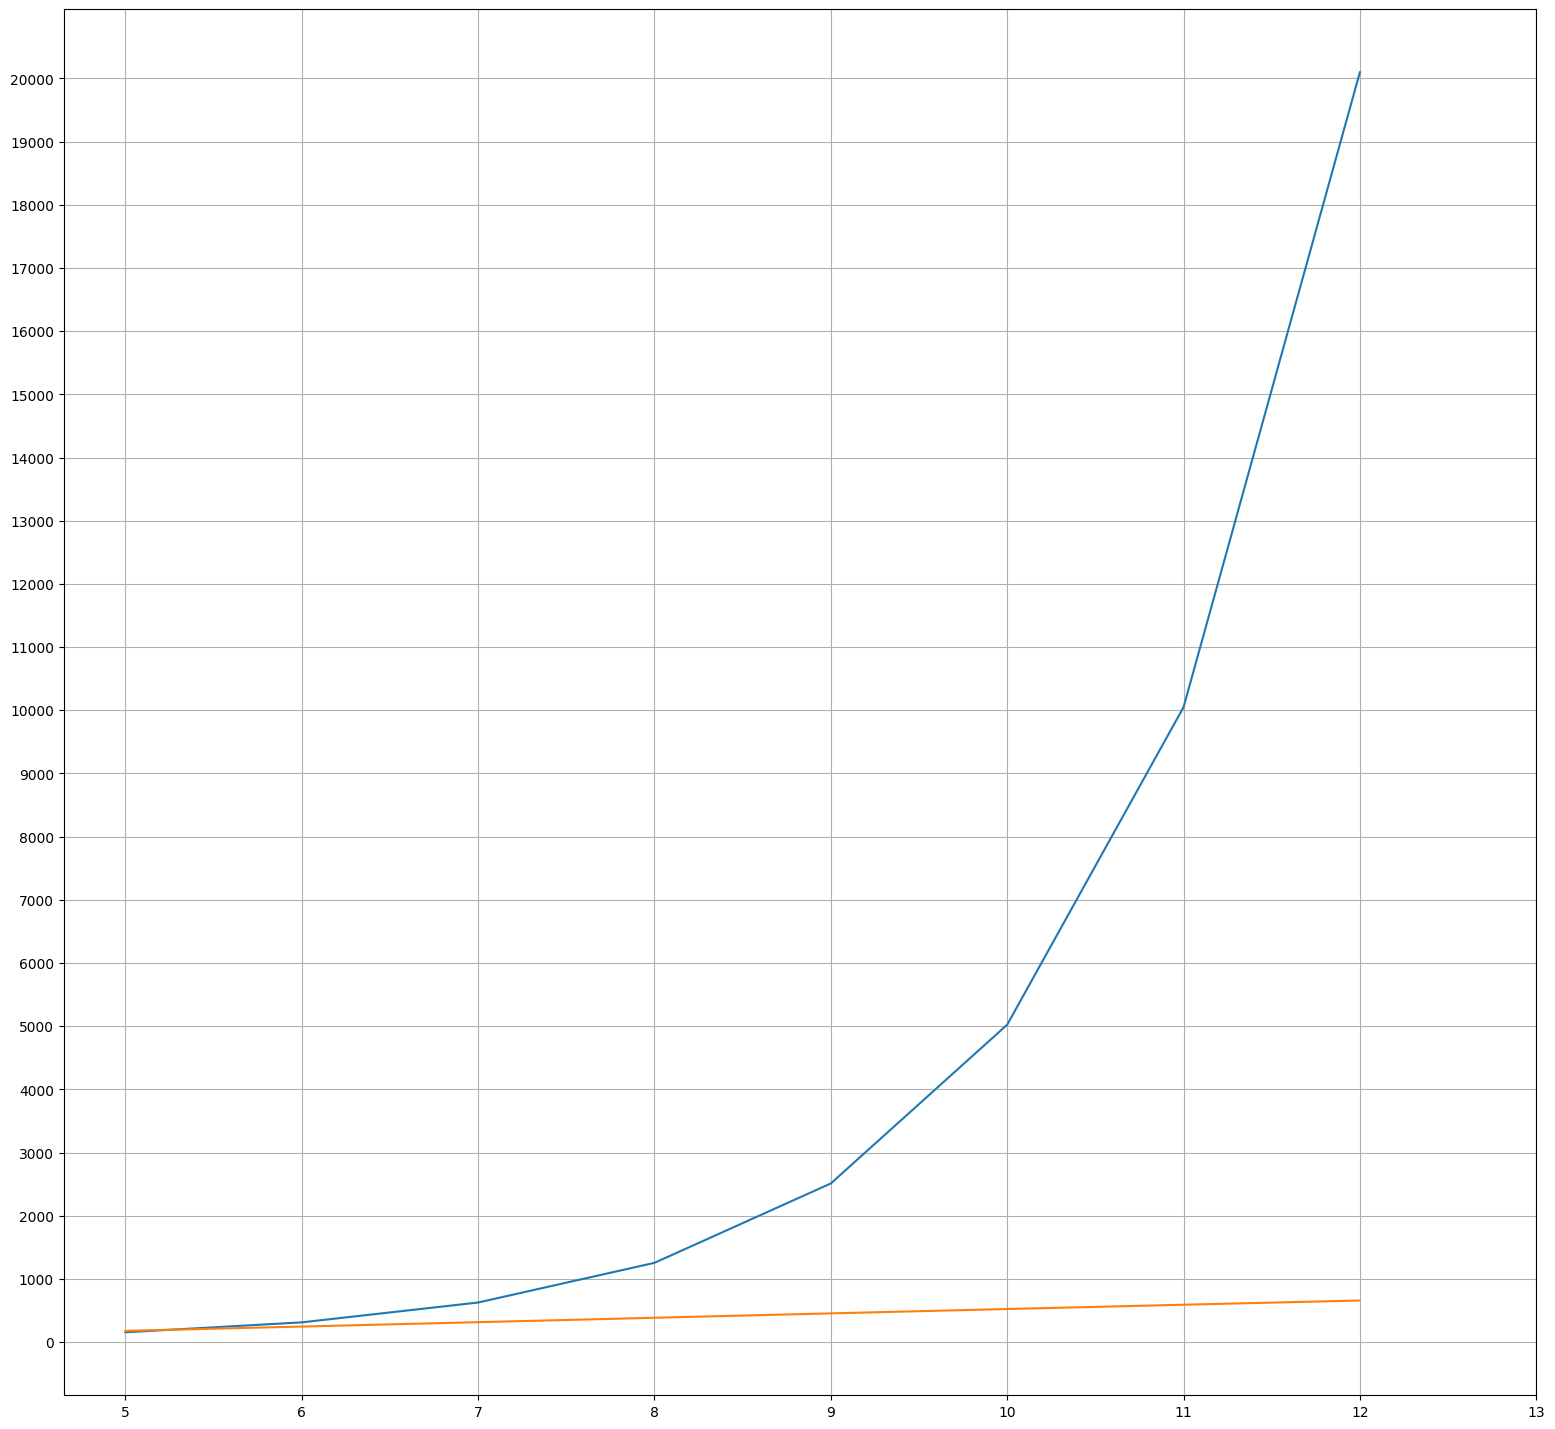

In [63]:
import matplotlib.pyplot as plt

cutoff = 8
# plt.plot(range(len(earlier_results)), earlier_results)

#plot original_depths
plt.plot(range(len(original_depths[:cutoff])), original_depths[:cutoff])

# plt.plot(range(len(earlier_results)), [43*np.log(el)**3 for el in range(5,len(earlier_results)+5)])
plt.plot(range(len(earlier_results[:cutoff])), [43*np.log(el)**3 for el in range(5,len(earlier_results[:cutoff])+5)])

plt.xticks(np.arange(0, len(earlier_results[:cutoff])+1, step=1), np.arange(5, len(earlier_results[:cutoff])+6, step=1))
plt.yticks(np.arange(0, original_depths[:cutoff][-1], step=1000))
#display grid
plt.grid()
fig = plt.gcf()
fig.set_size_inches(19, 18)
fig.show()